# 머신러닝 프로젝트 진행 과정
1. 큰 그림을 봅니다.
2. 데이터를 구합니다.
3. 데이터로부터 통찰을 얻기 위해 탐색하고 시각화합니다. 
4. 머신러닝 알고리즘을 위해 데이터를 준비합니다.
5. 모델을 선택하고 훈련시킵니다.
6. 모델을 상세하게 조정합니다.
7. 솔루션을 제시합니다.
8. 시스템을 론칭하고 모니터링하고 유지 보수합니다.

# 큰그림 보기

## 1. 문제정의
 - 비즈니스의 목적은 중간주택가격예측이 다른 신호와 함께 투자결정을 내리는 머신러닝 시스템의 입력으로 사용할 것임.
 - 선택: 지도/비지도/강화학습, 분류/회귀, 배치/온라인
     - 레이블된 샘플이 있으므로 지도학습
     - 연속된 값을 예측하므로 회귀문제
         - 예측에 사용할 특성이 여러개(구역의 인구, 중간소득 등)이므로 다변량회귀(mulitvariate regression)
         - 회귀란? https://brunch.co.kr/@gimmesilver/17
     - 데이터는 오프라인으로 준비되어 있고 크지 않으므로 배치 학습이 적당

## 2. 성능 측정 지표 선택
 - 회귀 문제의 전형적인 성능 지표는 평균 제곱근 오차 (Root Mean Square Error)

## 3. 가정 검사
 - 지금까지 만든 가정을 나열하고 검사

## 참고
### 머신러닝 파이프 라인 
 - 데이터 처리 컴포넌트component들이 연속되어 있는 것을 데이터 파이프라인 이라고 함.
 - 파이프라인
     - 머신러닝 알고리즘의 기반을 이루는 인프라
     - 프런트 엔드에서 데이터를 수집하고, 데이터를 학습 데이터 파일에 넣고, 하나 이상의 모델을 학습시키고, 모델을 프로덕션 환경으로 내보내는 과정
![머신러닝 파이프 라인](images/머신러닝파이프라인.png)

### 머신러닝 규칙 ( Google Developer )
https://developers.google.com/machine-learning/rules-of-ml/?hl=ko

## 캘리포니아 주택 가격 데이터셋
 - 1990년 캘리포니아 인구조사 데이터를 기반
 - 블록(600~3,000명 단위)마다 인구, 중간소득, 중간주택가격을 담고있음.
 - 이 데이터로 모델을 학습시켜서 다른 측정 데이터가 주어졌을 때 구역의 중간 주택 가격을 예측해야 함
![캘리포니아 주택 가격](images/캘리포니아주택가격.png)

In [40]:
# matplotlib 설정
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 맥이므로 애플고딕으로 설정
matplotlib.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴드
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 데이터 구조 훑어보기

In [5]:
import os
# 경로를 병합하여 새 경로 생성 
path = os.path.join("datas", "housing.csv")
path

'datas/housing.csv'

In [6]:
import pandas as pd

def load_housing_data():
    return pd.read_csv('datas/housing.csv')

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
# 20,640개 샘플
# total_bedrooms : 207개가 비어 있음
# ocean_proximity를 제외한 나머지는 float64(숫자형)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [8]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [9]:
# 숫자형 특성의 요약 정보
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


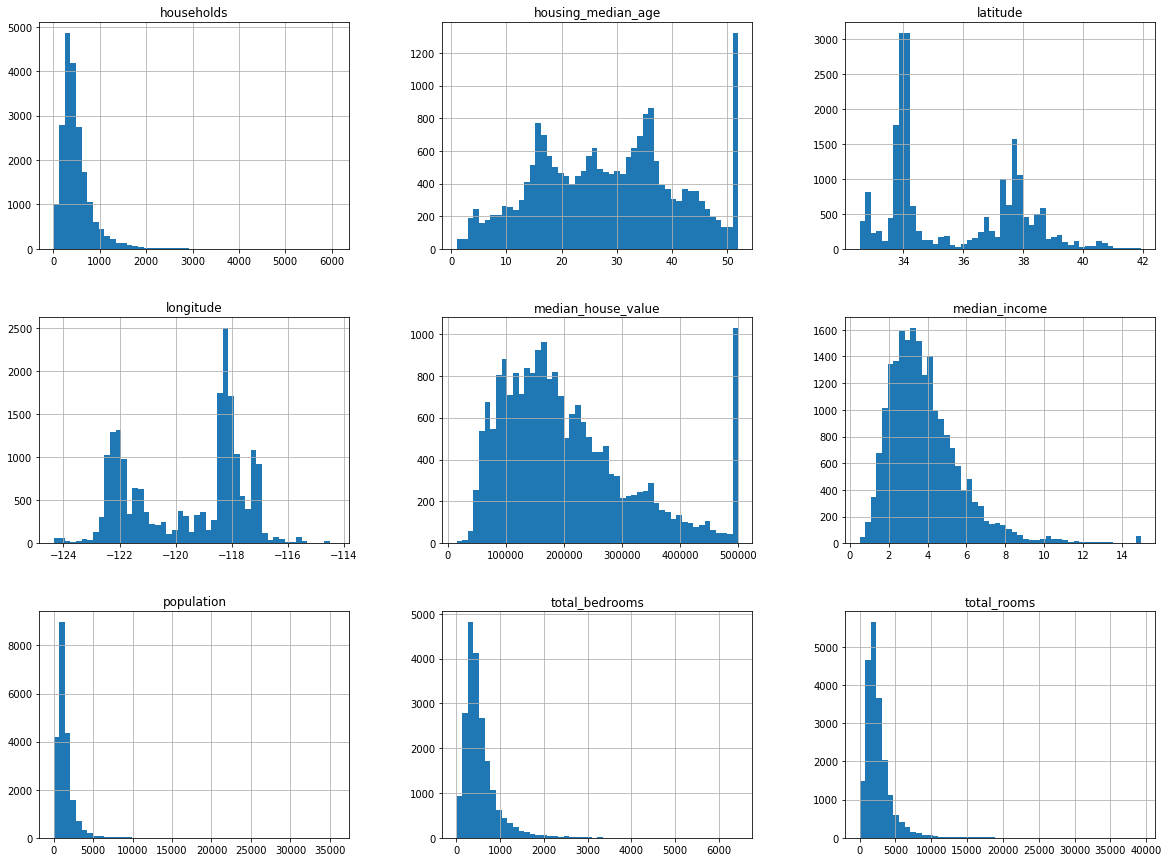

In [10]:
import matplotlib.pyplot as plt
# 숫자형 특성의 히스토그램을 그
housing.hist(bins=50, figsize=(20,15))
plt.show()

# 테스트 데이터
- 데이터를 더 자세히 파악하기 전에 테스트 데이터를 떼어 놓아야 함
- 전체 데이터에서 너무 많은 직관을 얻으면 과대적합된 모델이 만들어집니다(데이터 스누핑 편향)
- 테스트 세트로 일반화 오차를 추정하면 매우 낙관적인 추정이 되며 시스템을 론칭했을 때 기대한 성능이 나오지 않을 것

In [12]:
# 그냥 무작위로 어떤 샘플을 선택해 서 데이터셋의 20% 정도를 테스트 데이터로 만들기 
import numpy as np
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) 
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size] 
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [13]:
train_set, test_set = split_train_test(housing, 0.2)
print(len(train_set), "train +", len(test_set), "test")

16512 train + 4128 test


### 위의 split_train_test 메소드의 문제점 
- 함수를 실행할 때마다 다른 테스트 세트가 만들어 짐 

### 해결책
 - 1. 처음 실행에서 테스트 세트를 저장하고 다음번 실행에서 이를 불러들이는 것
 - 2. 항상 같은 난수 인덱스가 생성되도록 np.random.permutation()을 호출하기 전에 난수발생기의 초기값을 지정하는 것
     - (np.random.seed(42)).
 - 두 해법 모두 다음번에 업데이트된 데이터셋을 사용하려면 문제!!!
     - 따라서 샘플의 식별자를 해싱한 값을 기준으로 분리

In [14]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio)) 
    return data.loc[~in_test_set], data.loc[in_test_set]

In [15]:
housing_with_id = housing.reset_index() # ‘index’열이 추가된 데이터프레임이 반환됩니다. 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), "train +", len(test_set), "test")

# 행의 인덱스를 고유 식별자로 사용할 때 새 데이터는 데이터셋의 끝에 추가되어야 하고 어떤 행도 삭제되지 않아야 합니다
test_set.head()

16512 train + 4128 test


,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
5,5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
16,16,-122.27,37.85,52.0,1966.0,347.0,793.0,331.0,2.7750,152500.0,NEAR BAY
23,23,-122.27,37.84,52.0,1688.0,337.0,853.0,325.0,2.1806,99700.0,NEAR BAY


In [16]:
# 구역의 위도와 경도는 몇백 년 후까지 안정적이라고 보장할 수 있으므로 두값을 연결하여 다음과같이 ID 만들어야함
# 위치정보는 사실 정밀도가낮아 여러구역의ID 가동일해지므로 같은테스트세트 혹은 훈련세트에 들어가게 될것임.
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"] 
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")
print(len(train_set), "train +", len(test_set), "test")
test_set.head()

16322 train + 4318 test


,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
59,59,-122.29,37.82,2.0,158.0,43.0,94.0,57.0,2.5625,60000.0,NEAR BAY,-122252.18
60,60,-122.29,37.83,52.0,1121.0,211.0,554.0,187.0,3.3929,75700.0,NEAR BAY,-122252.17
61,61,-122.29,37.82,49.0,135.0,29.0,86.0,23.0,6.1183,75000.0,NEAR BAY,-122252.18
62,62,-122.29,37.81,50.0,760.0,190.0,377.0,122.0,0.9011,86100.0,NEAR BAY,-122252.19
67,67,-122.29,37.80,52.0,1027.0,244.0,492.0,147.0,2.6094,81300.0,NEAR BAY,-122252.20


In [17]:
# with scikit-learn
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)
print(len(train_set), "train +", len(test_set), "test")
test_set.head()

16512 train + 4128 test


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


## 계층적 샘플링
* 전체 인구를 대표할 수 있는 1,000명을 선택
    * 51.3%가 여성이고 48.7%가 남성이라면 여성은 513명, 남성은 487명이어야 함
    * 샘플에서도 이 비율을 유지 
    * 이를 계층적 샘플링 stratified sampling 이라고 함
* 만약 무작위로 샘플링한다면 여성에 테스트 샘플링에 들어갈 확률이 12%

# 전문가가 중간소득 (median_income) 중간 주택 가격을 예측하는 데 중요하다고 가정

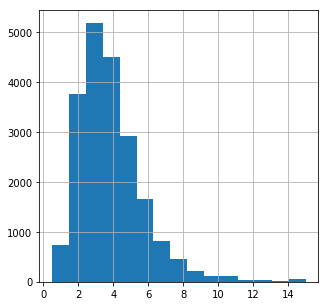

In [18]:
housing['median_income'].hist(bins=15, figsize=(5,5))
plt.show()

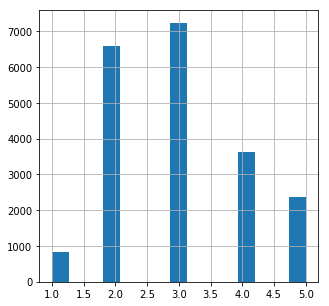

In [19]:
# 중간 소득이 연속적인 숫자형 특성이므로 소득에 대한 카테고리 특성을 만들어줌
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5) # 중간 소득을 1.5로 나누고, ceil 함수를 사용하여 반올림
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True) # 5보다 큰 카테고리는 5로 합칩

# 소득 카테고리 히스토그램
housing['income_cat'].hist(bins=15, figsize=(5,5))
plt.show()

# 소득 카테고리를 기반으로 계층 샘플링을 할 준비완료 됨 

In [20]:
# 소득 카테고리를 기반으로 계층 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42) 
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index] 
    strat_test_set = housing.loc[test_index]

housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64

In [21]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3.0    0.350533
2.0    0.318798
4.0    0.176357
5.0    0.114583
1.0    0.039729
Name: income_cat, dtype: float64

In [22]:
housing["income_cat"].value_counts() / len(housing)

3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64

In [27]:
# 계층 샘플링과 순수한 무작위 샘플링의 샘플링 편향 비교
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Random. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Stratified. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

compare_props

,Overall,Random,Stratified,Random. %error,Stratified. %error
1.0,0.039826,0.040213,0.039729,0.973236,-0.243309
2.0,0.318847,0.324370,0.318798,1.732260,-0.015195
3.0,0.350581,0.358527,0.350533,2.266446,-0.013820
4.0,0.176308,0.167393,0.176357,-5.056334,0.027480
5.0,0.114438,0.109496,0.114583,-4.318374,0.127011


In [28]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 데이터 이해를 위한 탐색과 시각화


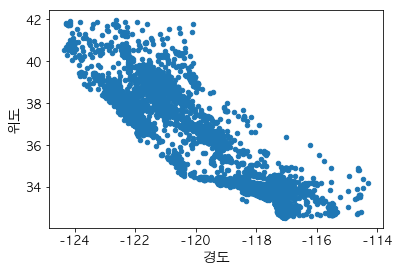

In [41]:
# 련 세트를 손상시키지 않기 위해 복사본을 만들어 사용
housing = strat_train_set.copy()

# 데이터의 지리적인 산점도 
# 캘리포니아 지역을 잘 나타내지만 어떤 특별한 패턴이 없어 보임 
ax = housing.plot(kind="scatter", x="longitude", y="latitude")
ax.set(xlabel='경도', ylabel='위도')
plt.show()

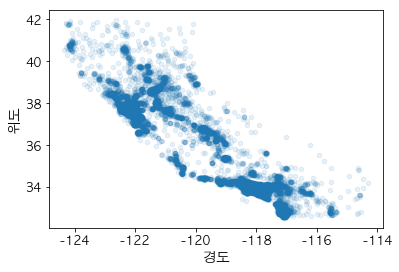

In [42]:
# alpha 옵션 을 0.1로 주면 데이터 포인트가 밀집된 영역을 잘 보여줌
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)
ax.set(xlabel='경도', ylabel='위도')
plt.show()

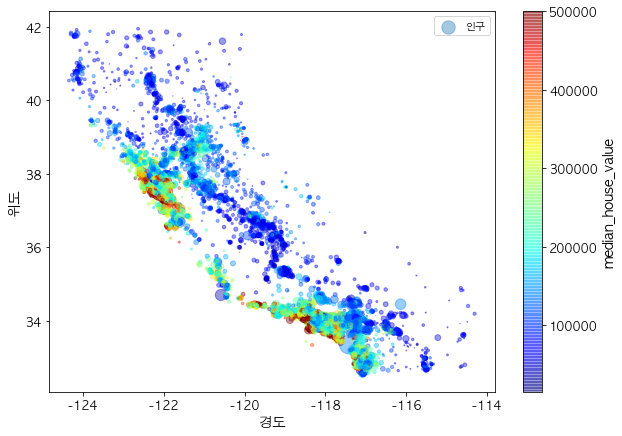

In [45]:
# s : 원의 반지름은 구역의 인구
# c : 색깔은 가격 
# cmap : 파란색(낮은 가격)에서 빨간색(높은 가격)으로 표시
ax = housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="인구", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)
ax.set(xlabel='경도', ylabel='위도')
plt.legend()
plt.show()

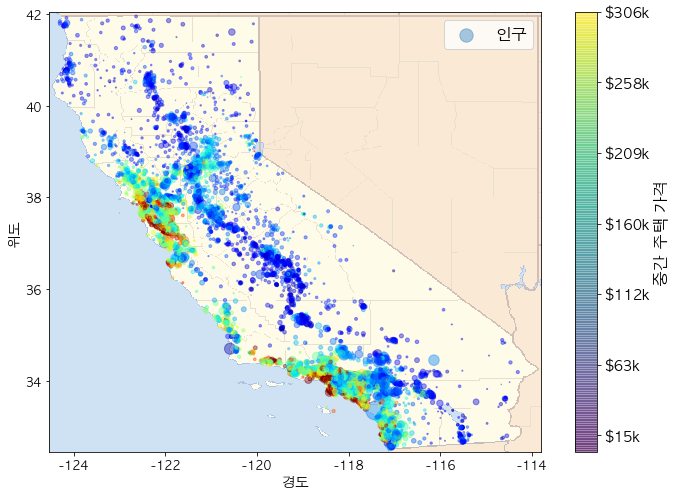

In [47]:
import matplotlib.image as mpimg
california_img=mpimg.imread(PROJECT_ROOT_DIR + '/images/end_to_end_project/california.png')
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="인구",
                       c="median_house_value", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5)
plt.ylabel("위도", fontsize=14)
plt.xlabel("경도", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('중간 주택 가격', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

# 이 그림에서 주택 가격은 지역(예를 들면 바다와 인접한 곳)과 인구 밀도에 관련이 매우 크다는 사실을 발견할 수 있음

# 상관관계 조사